In [1]:
import numpy as np
from scipy.integrate import solve_ivp

from simulator import OrbitSimulator
from plotting import *
import constants as const

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:

    s0 = np.linalg.norm(s0)
    w = np.sqrt(const.MU_EARTH_KM / s0**3)
    t_range = np.arange(t_span[0], t_span[1], dt)

    x = s0 * np.cos(w * t_range)
    y = s0 * np.sin(w * t_range)
    vx = -s0 * w * np.sin(w * t_range)
    vy = s0 * w * np.cos(w * t_range)

    results = np.column_stack([x, y, np.zeros_like(x), vx, vy, np.zeros_like(x)])

    return t_range, results

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:
    def keplerian_rhs(t, s):
        r, v = s[:3], s[3:]
        a = -const.MU_EARTH_KM / np.linalg.norm(r)**3 * r
        return np.hstack([v, a])
    
    times = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(fun=keplerian_rhs, t_span=t_span, y0=s0, t_eval=times, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y.T



/home/roi/anaconda3/envs/satellite/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [24]:
def run_full_simulation():
    print("--- Running Final Simulation with PD Controller (with Deadband) ---")

    duration_days = 1.0
    dt = 60.0 
    t_span = (0, duration_days * 24 * 3600)

    # These are our "true" parameters that we'll try to recover
    true_satellite_params = {'C_R': 1.5, 'A': 20.0, 'm': 1000.0}
    true_policy_params = {
        'gamma': 100.0,
        'Kp':  5e-4,
        'Kd': 5e-3,
        'beta': 0.5
    }
    true_sigma =  1e-5

    # Generate the data
    simulator = OrbitSimulator(
        satellite_params=true_satellite_params,
        policy_params=true_policy_params,
        sigma=true_sigma
    )
    ref_times, ref_states = generate_reference_trajectory(const.S0_KM, t_span, dt)
    sim_times, sim_states, _ = simulator.simulate_SLV(const.S0_KM, t_span, dt, ref_states)

    df = simulator.get_log()

    
    print("Simulation complete.")


    plot2d(df)
    plot3d(df)
    plot_acceleration_components(log_df=df)
    # plot_controller_performance(log_df=df, policy_params=true_policy_params)
    plot_control_acceleration(log_df=df)
    plot_position_error(log_df=df, policy_params=true_policy_params)


    return df

--- Running Final Simulation with PD Controller (with Deadband) ---
Precomputing ephemeris data...
Simulation complete.


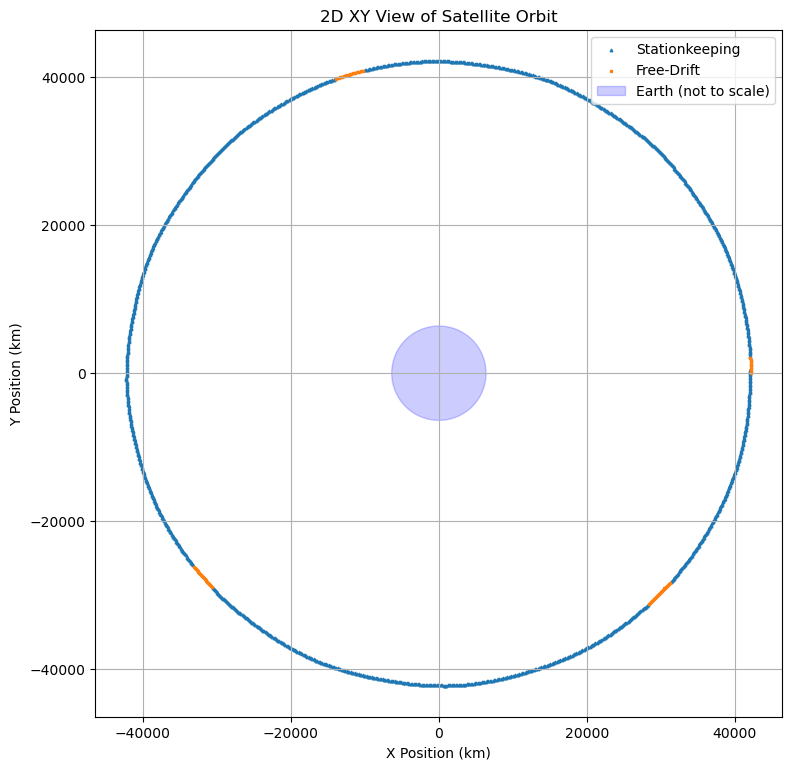

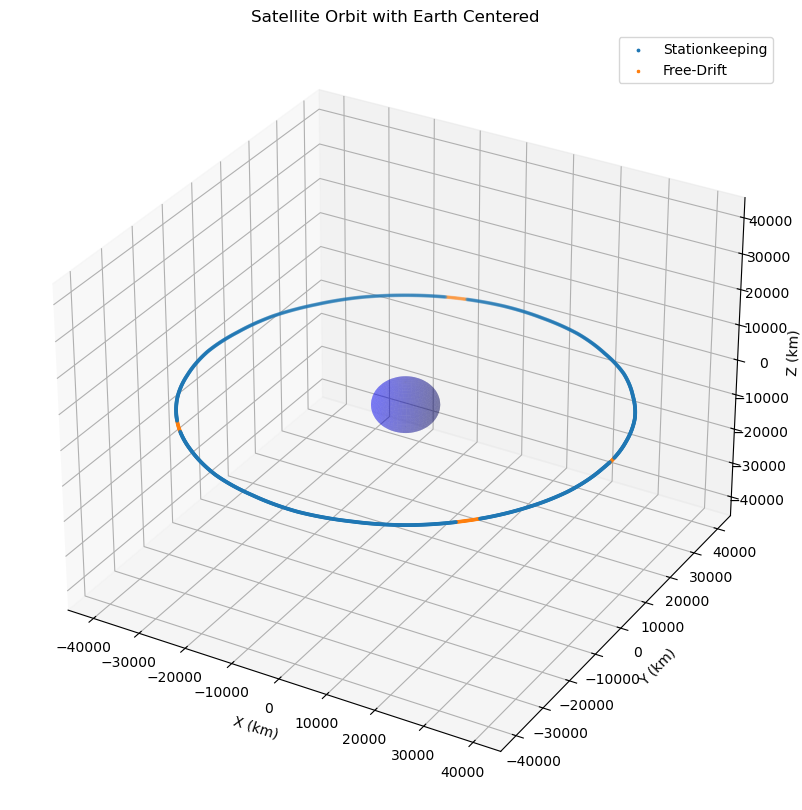

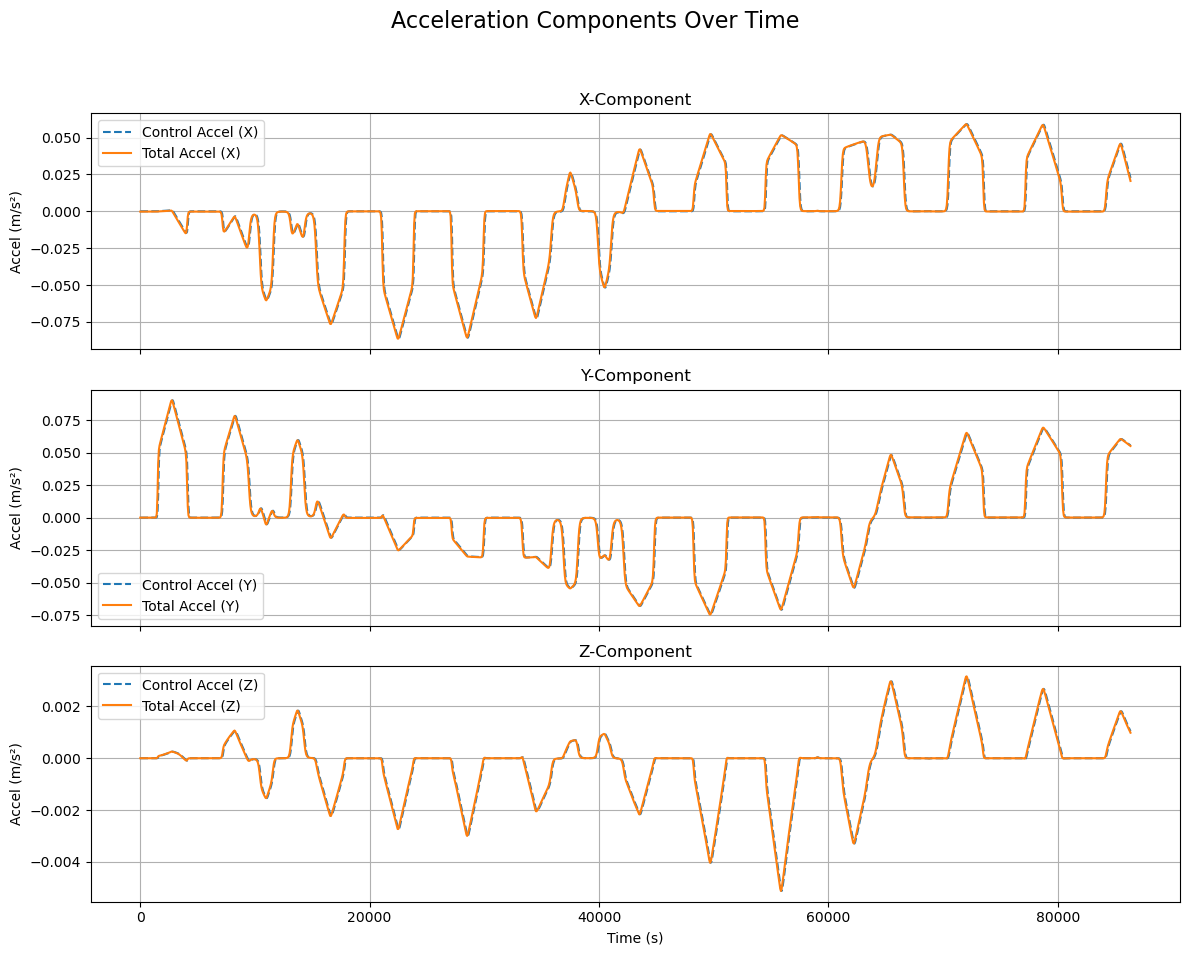

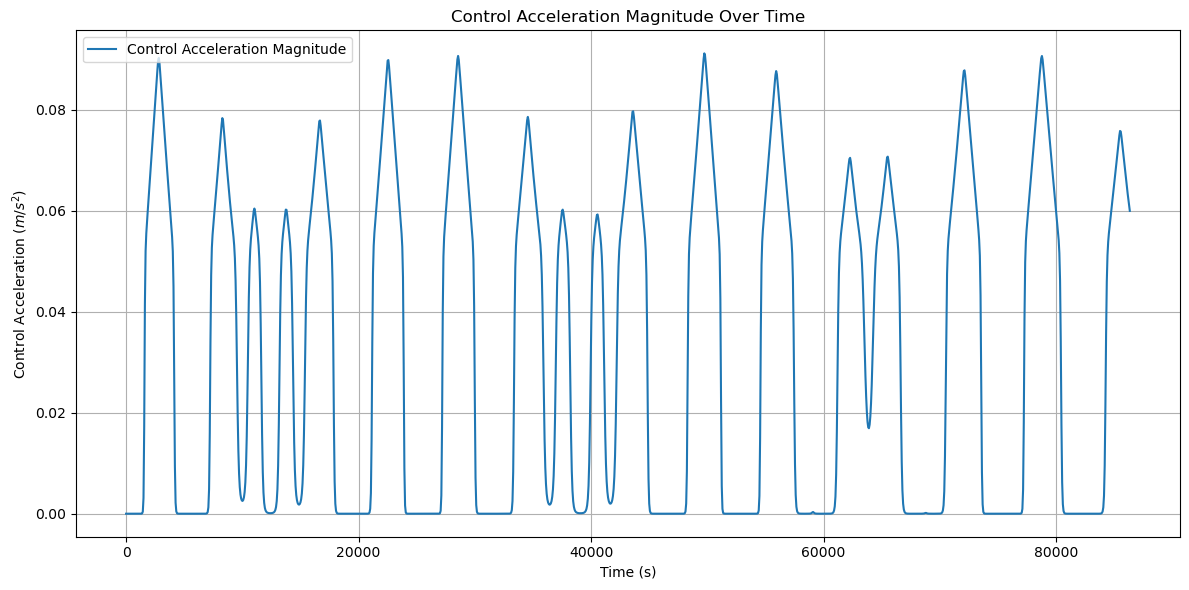

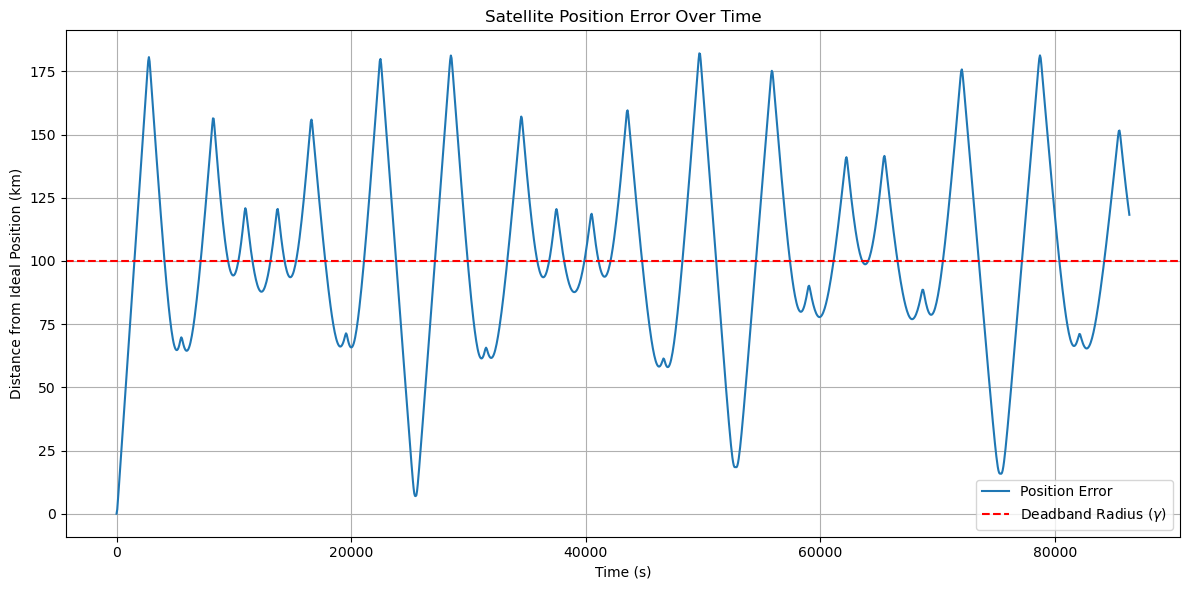

In [25]:
df = run_full_simulation()

In [26]:
df

,Time (s),Satellite ID,Longitude (deg),X (km),Y (km),Z (km),VX (km/s),VY (km/s),VZ (km/s),ideal X (km),...,ideal VX (km/s),ideal VY (km/s),ideal VZ (km/s),Status,Control Accel (X),Control Accel (Y),Control Accel (Z),Total Accel (X),Total Accel (Y),Total Accel (Z)
0,0.0,Geosat-1,0.000000,42164.137000,0.000000,0.000000,0.000000,3.074661,0.000000,42164.137000,...,0.000000,3.074661,0.0,non-stationkeeping,0.000000e+00,0.000000e+00,0.000000e+00,-0.000224,-4.148394e-09,-2.168510e-09
1,60.0,Geosat-1,0.248403,42163.730871,182.799568,-0.001587,-0.013538,3.018658,-0.000053,42163.733426,...,-0.013452,3.074632,0.0,non-stationkeeping,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000224,-9.761937e-07,-2.132052e-09
2,120.0,Geosat-1,0.494108,42162.516738,363.610322,-0.005231,-0.026933,3.008367,-0.000069,42162.522712,...,-0.026905,3.074544,0.0,non-stationkeeping,7.609553e-28,5.000975e-25,4.726169e-28,-0.000224,-1.937669e-06,-2.084964e-09
3,180.0,Geosat-1,0.739338,42160.498876,544.063973,-0.010922,-0.040329,3.006754,-0.000121,42160.504881,...,-0.040356,3.074396,0.0,non-stationkeeping,8.739839e-27,8.381928e-24,8.256318e-27,-0.000224,-2.897258e-06,-2.027032e-09
4,240.0,Geosat-1,0.984503,42157.675741,724.458936,-0.021399,-0.053776,3.006411,-0.000228,42157.679971,...,-0.053807,3.074190,0.0,non-stationkeeping,5.949784e-26,1.042576e-22,1.260589e-25,-0.000224,-3.856555e-06,-1.943650e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,86100.0,Geosat-1,-0.422382,42107.008818,-310.416406,-2.439422,0.074584,3.087901,0.001918,42163.678048,...,0.014347,3.074628,0.0,stationkeeping,2.983999e-02,5.716427e-02,1.268155e-03,0.027809,5.676915e-02,1.210130e-03
1436,86160.0,Geosat-1,-0.170266,42111.076914,-125.141790,-2.326600,0.061019,3.087919,0.001843,42164.135305,...,0.000895,3.074661,0.0,stationkeeping,2.803339e-02,5.676750e-02,1.210120e-03,0.026004,5.637025e-02,1.154090e-03
1437,86220.0,Geosat-1,0.081814,42114.337334,60.136381,-2.215250,0.047661,3.088020,0.001869,42163.785413,...,-0.012558,3.074636,0.0,stationkeeping,2.622846e-02,5.636959e-02,1.154081e-03,0.024198,5.596866e-02,1.098275e-03
1438,86280.0,Geosat-1,0.333862,42116.793051,245.417092,-2.101093,0.034196,3.088004,0.001936,42162.628380,...,-0.026010,3.074551,0.0,stationkeeping,2.442263e-02,5.596899e-02,1.098267e-03,0.022391,5.556354e-02,1.040833e-03
